In [1]:
## By default sparkContext is created --sc
from pyspark.sql import SparkSession
sk = SparkSession.builder.appName("CrimeAnalysis").getOrCreate()
import pandas as pd   
import matplotlib.pyplot as plt ## => library used for visualizations, that work on pandas dataframes
%matplotlib inline
### 1. creating a schema -- not necessary => pyspark can analyze schema itself as well
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)



CrimeSchema = StructType    ([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])
## Creating a dataframe by reading a csv file and applying schema created on top of it
crimeDf= sk.read.csv('*://**//**//SPARK//Crimes_-_2001_to_present.csv',header=True,schema=CrimeSchema) # put file schema

print(crimeDf.count()) ## number of rows
print(len(crimeDf.columns)) ##number of columns

crimeDf.select("ID","CaseNumber","Date","Arrest").show(5) ## showing data for few cols



6852783
22
+--------+----------+--------------------+------+
|      ID|CaseNumber|                Date|Arrest|
+--------+----------+--------------------+------+
|11658740|  JC228615|04/17/2019 11:58:...| false|
|11658604|  JC228613|04/17/2019 11:56:...| false|
|11658609|  JC228620|04/17/2019 11:55:...|  true|
|11658631|  JC228628|04/17/2019 11:53:...| false|
|11658603|  JC228612|04/17/2019 11:49:...| false|
+--------+----------+--------------------+------+
only showing top 5 rows



In [2]:
## Basic Analysis ##
## 1. Different Type of crimes
#crimeDf.select("PrimaryType").distinct().show(100)
## 2. Different Areas where crimes were observed
#crimeDf.select("LocationDescription").distinct().show(100)



In [18]:
## Analyze number of crimes yearly
crimeDf.groupBy("Year").count().show()

+----+------+
|Year| count|
+----+------+
|2003|475946|
|2007|437014|
|2018|266480|
|2015|264092|
|2006|448112|
|2013|307113|
|2014|275301|
|2019| 68127|
|2004|469384|
|2012|335978|
|2009|392686|
|2016|269021|
|2001|485754|
|2005|453717|
|2010|370317|
|2011|351784|
|2008|427062|
|2017|268140|
|2002|486755|
+----+------+



In [19]:
crimeDf.createOrReplaceTempView("crime") 
## to apply sql queries you need to create temp view/table using createOrReplaceTempView()


In [12]:
numCrimes=crimeDf.groupby("Year","PrimaryType").count().orderBy('Year').show()

+----+--------------------+-----+
|Year|         PrimaryType|count|
+----+--------------------+-----+
|2001|             ROBBERY|18441|
|2001|             BATTERY|93446|
|2001|            STALKING|  203|
|2001| MOTOR VEHICLE THEFT|27549|
|2001|        PROSTITUTION| 6026|
|2001|           RITUALISM|    8|
|2001|           OBSCENITY|   19|
|2001|             ASSAULT|31384|
|2001|               ARSON| 1010|
|2001|               THEFT|99264|
|2001|     CRIMINAL DAMAGE|55851|
|2001|   CRIMINAL TRESPASS|13240|
|2001|    PUBLIC INDECENCY|    9|
|2001|            GAMBLING|  934|
|2001|          KIDNAPPING|  933|
|2001|INTERFERENCE WITH...|  406|
|2001|OFFENSE INVOLVING...| 2244|
|2001|           NARCOTICS|50567|
|2001|       OTHER OFFENSE|29657|
|2001|OTHER NARCOTIC VI...|    6|
+----+--------------------+-----+
only showing top 20 rows



In [8]:
## count of different types of crimes every year
## using sql Query
NumOfCrimes= sqlContext.sql('select Year,PrimaryType,count(*) as NumberOfCrime from crime group by Year,PrimaryType order by cast(Year as Integer)')
NumOfCrimes.show(20)
## using dataframe functions
numCrimes=crimeDf.groupby("Year","PrimaryType").count().orderBy('Year').show()


+----+--------------------+-------------+
|Year|         PrimaryType|NumberOfCrime|
+----+--------------------+-------------+
|2001|             ROBBERY|        18441|
|2001|           RITUALISM|            8|
|2001|            STALKING|          203|
|2001|        PROSTITUTION|         6026|
|2001|             BATTERY|        93446|
|2001|    PUBLIC INDECENCY|            9|
|2001|           OBSCENITY|           19|
|2001|             ASSAULT|        31384|
|2001|               THEFT|        99264|
|2001|     CRIMINAL DAMAGE|        55851|
|2001|OFFENSE INVOLVING...|         2244|
|2001|       OTHER OFFENSE|        29657|
|2001|   CRIMINAL TRESPASS|        13240|
|2001|               ARSON|         1010|
|2001|            GAMBLING|          934|
|2001|INTERFERENCE WITH...|          406|
|2001|          KIDNAPPING|          933|
|2001|           NARCOTICS|        50567|
|2001| MOTOR VEHICLE THEFT|        27549|
|2001|OTHER NARCOTIC VI...|            6|
+----+--------------------+-------

In [19]:
## % of differnt crimes all these years
CrimePerc= sqlContext.sql('select PrimaryType,100*count(*)/(select count(*) from crime where PrimaryType is not Null) as CrimePercent\
                           from crime \
                           group by PrimaryType')
CrimePerc.show(200)

+--------------------+--------------------+
|         PrimaryType|        CrimePercent|
+--------------------+--------------------+
|OFFENSE INVOLVING...|  0.6770388030673086|
|            STALKING|0.050694732344508796|
|PUBLIC PEACE VIOL...|  0.7063115817325604|
|           OBSCENITY|0.008799344733373288|
|NON-CRIMINAL (SUB...|1.313335034831834E-4|
|               ARSON| 0.16491110254038396|
|   DOMESTIC VIOLENCE|1.459261149813148...|
|            GAMBLING| 0.21070271742152058|
|   CRIMINAL TRESPASS|  2.8620926709630234|
|             ASSAULT|   6.223996878348548|
|      NON - CRIMINAL|5.545192369289966E-4|
|LIQUOR LAW VIOLATION| 0.20628115613758674|
| MOTOR VEHICLE THEFT|   4.642624755519035|
|               THEFT|   21.05579587154591|
|             BATTERY|  18.261923659336652|
|             ROBBERY|  3.7788005252756434|
|            HOMICIDE| 0.14049766350400997|
|           RITUALISM|3.356300644570242...|
|    PUBLIC INDECENCY|0.002393188285693...|
| CRIM SEXUAL ASSAULT| 0.4074111

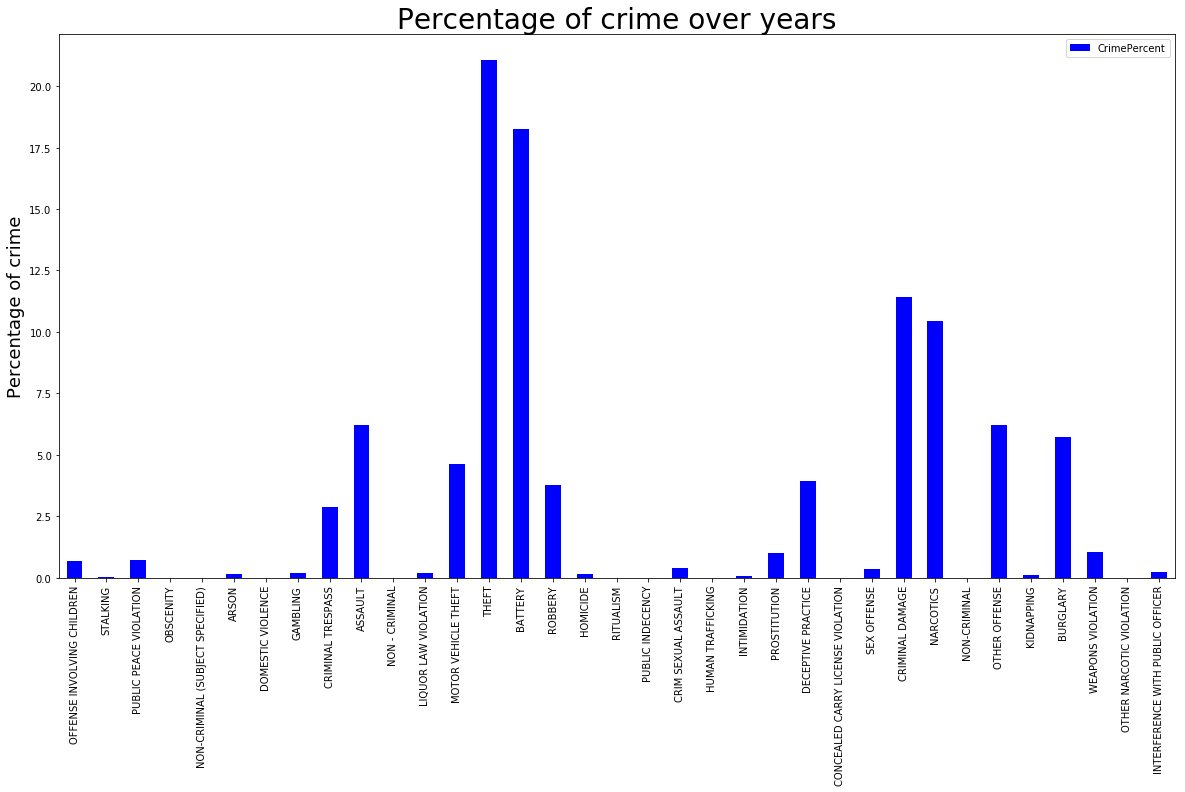

In [20]:

crimePercpd=CrimePerc.toPandas()
crimePercpd.plot(figsize = (20,10), kind = "bar", color = "blue",
                              x = "PrimaryType", y = "CrimePercent")
plt.xlabel("", fontsize = 18)
plt.ylabel("Percentage of crime", fontsize = 18)
plt.title("Percentage of crime over years", fontsize = 28)
plt.xticks(size = 10)
plt.yticks(size = 10)

plt.show()

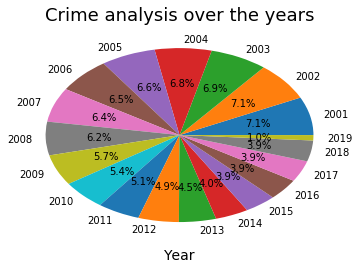

In [15]:
## Count of crimes over the years

NumOfCrimesOverYears= sqlContext.sql('select Year,count(*)as cnt from crime group by year order by Year')
NumOfCrimesOverYearspd= NumOfCrimesOverYears.toPandas()
#NumOfCrimesOverYearspd.plot(figsize = (20,10), kind = "line", color = "red",
#                              x = "Year", y = "cnt")
plt.pie(x=NumOfCrimesOverYearspd.cnt,labels=NumOfCrimesOverYearspd.Year,autopct='%1.1f%%')
plt.xlabel("Year", fontsize = 14)

plt.title("Crime analysis over the years", fontsize = 18)

plt.show()